# Blob Inclusion

Analysis of blob inclusion patterns in Ethereum mainnet blocks.

In [1]:
import altair as alt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

from lib import (
    get_client_optional,
    load_or_query,
    setup_altair,
    show_fig,
    DEFAULT_NETWORK,
)

# =============================================================================
# PARAMETERS
# =============================================================================
NETWORK = DEFAULT_NETWORK
FORCE_QUERY = False  # Set to True to refresh cached data

# =============================================================================
# SETUP
# =============================================================================
client = get_client_optional()
setup_altair()

## Blobs included per slot

In [2]:
# Panel 1: Blobs per slot
sql_blobs_per_slot = f"""
SELECT
    s.slot_start_date_time AS time,
    COALESCE(b.blob_count, 0) AS blob_count
FROM (
    SELECT DISTINCT slot_start_date_time
    FROM default.canonical_beacon_block
    WHERE meta_network_name = '{NETWORK}'
      AND slot_start_date_time >= now() - INTERVAL 24 HOUR
) s
LEFT JOIN (
    SELECT
        slot_start_date_time,
        COUNT(*) AS blob_count
    FROM default.canonical_beacon_blob_sidecar
    WHERE meta_network_name = '{NETWORK}'
      AND slot_start_date_time >= now() - INTERVAL 24 HOUR
    GROUP BY slot_start_date_time
) b ON s.slot_start_date_time = b.slot_start_date_time
ORDER BY s.slot_start_date_time ASC
"""

df_blobs_per_slot = load_or_query(client, sql_blobs_per_slot, "blobs_per_slot", FORCE_QUERY)

Loading from cache: blobs_per_slot.parquet


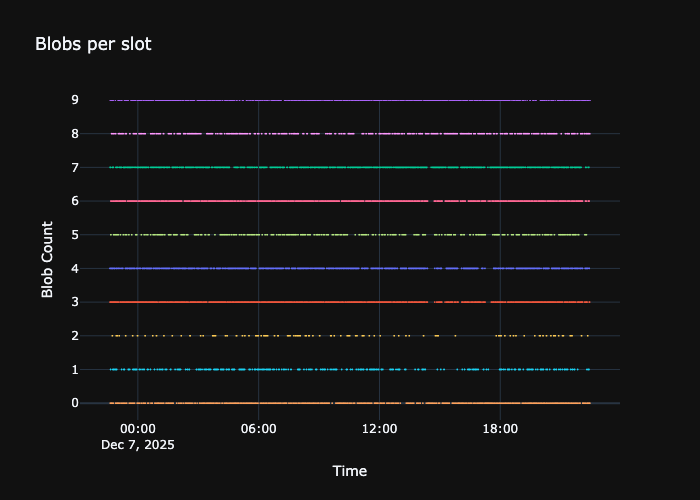

In [3]:
fig = px.scatter(
    df_blobs_per_slot,
    x="time",
    y="blob_count",
    color="blob_count",
    color_continuous_scale="YlOrRd",
    title="Blobs per slot",
    labels={"time": "Time", "blob_count": "Blob Count"},
    template="plotly_dark",
)
fig.update_layout(
    showlegend=False,
    yaxis=dict(dtick=1, range=[-0.5, 9]),
    coloraxis_colorbar=dict(title="Blobs"),
)
fig.update_traces(marker=dict(size=2))
show_fig(fig)

## Blob count breakdown per epoch

In [4]:
sql_blocks_blob_epoch = f"""
WITH blob_counts_per_slot AS (
    SELECT
        slot,
        epoch,
        epoch_start_date_time,
        slot_start_date_time,
        toUInt64(max(blob_index) + 1) as blob_count
    FROM canonical_beacon_blob_sidecar
    WHERE meta_network_name = '{NETWORK}'
      AND slot_start_date_time >= now() - INTERVAL 24 HOUR
    GROUP BY slot, epoch, epoch_start_date_time, slot_start_date_time
),
blocks_per_epoch AS (
    SELECT
        epoch,
        epoch_start_date_time,
        toUInt64(COUNT(*)) as total_blocks
    FROM canonical_beacon_block
    WHERE meta_network_name = '{NETWORK}'
      AND slot_start_date_time >= now() - INTERVAL 24 HOUR
    GROUP BY epoch, epoch_start_date_time
),
epochs AS (
    SELECT DISTINCT epoch, epoch_start_date_time
    FROM blocks_per_epoch
),
all_blob_counts AS (
    SELECT arrayJoin(range(toUInt64(0), toUInt64(max(blob_count) + 1))) AS blob_count
    FROM blob_counts_per_slot
),
all_combinations AS (
    SELECT
        e.epoch,
        e.epoch_start_date_time,
        b.blob_count
    FROM epochs e
    CROSS JOIN all_blob_counts b
),
block_per_blob_count_per_epoch AS (
    SELECT
        epoch,
        epoch_start_date_time,
        blob_count,
        toUInt64(COUNT(*)) as block_count
    FROM blob_counts_per_slot
    GROUP BY epoch, epoch_start_date_time, blob_count
),
blocks_with_blobs_per_epoch AS (
    SELECT
        epoch,
        toUInt64(COUNT(*)) as blocks_with_blobs
    FROM blob_counts_per_slot
    GROUP BY epoch
)
SELECT
    a.epoch_start_date_time AS time,
    concat(lpad(toString(a.blob_count), 2, '0'), ' blobs') AS series,
    CASE
        WHEN a.blob_count = 0 THEN
            toInt64(COALESCE(blk.total_blocks, toUInt64(0))) - toInt64(COALESCE(wb.blocks_with_blobs, toUInt64(0)))
        ELSE
            toInt64(COALESCE(b.block_count, toUInt64(0)))
    END as block_count
FROM all_combinations a
GLOBAL LEFT JOIN block_per_blob_count_per_epoch b
    ON a.epoch = b.epoch AND a.blob_count = b.blob_count
GLOBAL LEFT JOIN blocks_per_epoch blk
    ON a.epoch = blk.epoch
GLOBAL LEFT JOIN blocks_with_blobs_per_epoch wb
    ON a.epoch = wb.epoch
ORDER BY a.blob_count ASC, a.epoch_start_date_time ASC
"""

df_blocks_blob_epoch = load_or_query(client, sql_blocks_blob_epoch, "blocks_blob_epoch", FORCE_QUERY)

Loading from cache: blocks_blob_epoch.parquet


In [5]:
chart = (
    alt.Chart(df_blocks_blob_epoch)
    .mark_bar()
    .encode(
        x=alt.X("time:T", title="Epoch Start Time"),
        y=alt.Y("block_count:Q", title="Block Count", stack="zero", scale=alt.Scale(domain=[0, 32]), axis=alt.Axis(tickCount=32, labelAngle=-45)),
        color=alt.Color(
            "series:N",
            title="Blob Count",
            sort="ascending",
            scale=alt.Scale(scheme="inferno"),
        ),
        order=alt.Order("series:N", sort="ascending"),
        tooltip=["time:T", "series:N", "block_count:Q"],
    )
    .properties(title="Blocks with blob counts per epoch", width=1000, height=600)
)
chart

alt.Chart(...)

## Blob count popularity per epoch

In [6]:
sql_blob_popularity = f"""
WITH blob_counts_per_slot AS (
    SELECT
        slot_start_date_time,
        epoch_start_date_time,
        toUInt64(max(blob_index) + 1) as blob_count
    FROM canonical_beacon_blob_sidecar
    WHERE meta_network_name = '{NETWORK}'
      AND slot_start_date_time >= now() - INTERVAL 24 HOUR
    GROUP BY slot, slot_start_date_time, epoch_start_date_time
),
blocks AS (
    SELECT
        slot_start_date_time,
        epoch_start_date_time
    FROM canonical_beacon_block
    WHERE meta_network_name = '{NETWORK}'
      AND slot_start_date_time >= now() - INTERVAL 24 HOUR
),
blocks_with_blob_count AS (
    SELECT
        b.epoch_start_date_time as time,
        COALESCE(bc.blob_count, toUInt64(0)) as blob_count
    FROM blocks b
    GLOBAL LEFT JOIN blob_counts_per_slot bc ON b.slot_start_date_time = bc.slot_start_date_time
)
SELECT
    time,
    blob_count,
    COUNT(*) as count
FROM blocks_with_blob_count
GROUP BY time, blob_count
ORDER BY time ASC, blob_count ASC
"""

df_blob_popularity = load_or_query(client, sql_blob_popularity, "blob_popularity", FORCE_QUERY)

# Pivot for heatmap
df_pivot = df_blob_popularity.pivot(index="blob_count", columns="time", values="count").fillna(0)

Loading from cache: blob_popularity.parquet


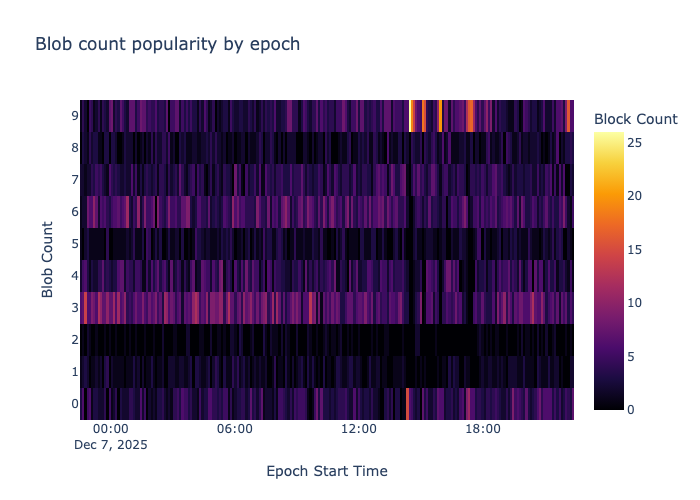

In [7]:
fig = go.Figure(
    data=go.Heatmap(
        z=df_pivot.values,
        x=df_pivot.columns,
        y=[str(int(b)) for b in df_pivot.index],
        colorscale="inferno",
        reversescale=False,
        colorbar=dict(title="Block Count"),
    ),
)
fig.update_layout(
    template="plotly_white",
    title="Blob count popularity by epoch",
    xaxis_title="Epoch Start Time",
    yaxis_title="Blob Count",
    height=500,
)
show_fig(fig)

## Blob count per slot (vertical layout)

In [8]:
sql_slot_in_epoch = f"""
WITH blob_counts_per_slot AS (
    SELECT
        slot,
        epoch,
        epoch_start_date_time,
        toUInt64(max(blob_index) + 1) as blob_count
    FROM canonical_beacon_blob_sidecar
    WHERE meta_network_name = '{NETWORK}'
      AND slot_start_date_time >= now() - INTERVAL 24 HOUR
    GROUP BY slot, epoch, epoch_start_date_time
),
blocks AS (
    SELECT
        slot,
        epoch,
        epoch_start_date_time
    FROM canonical_beacon_block
    WHERE meta_network_name = '{NETWORK}'
      AND slot_start_date_time >= now() - INTERVAL 24 HOUR
),
blocks_with_blob_count AS (
    SELECT
        b.slot,
        b.epoch,
        b.epoch_start_date_time,
        b.slot - (b.epoch * 32) as slot_in_epoch,
        COALESCE(bc.blob_count, toUInt64(0)) as blob_count
    FROM blocks b
    GLOBAL LEFT JOIN blob_counts_per_slot bc
        ON b.slot = bc.slot AND b.epoch = bc.epoch
)
SELECT
    epoch_start_date_time as time,
    slot_in_epoch,
    blob_count
FROM blocks_with_blob_count
ORDER BY time ASC, slot_in_epoch ASC
"""

df_slot_in_epoch = load_or_query(client, sql_slot_in_epoch, "slot_in_epoch", FORCE_QUERY)

Loading from cache: slot_in_epoch.parquet


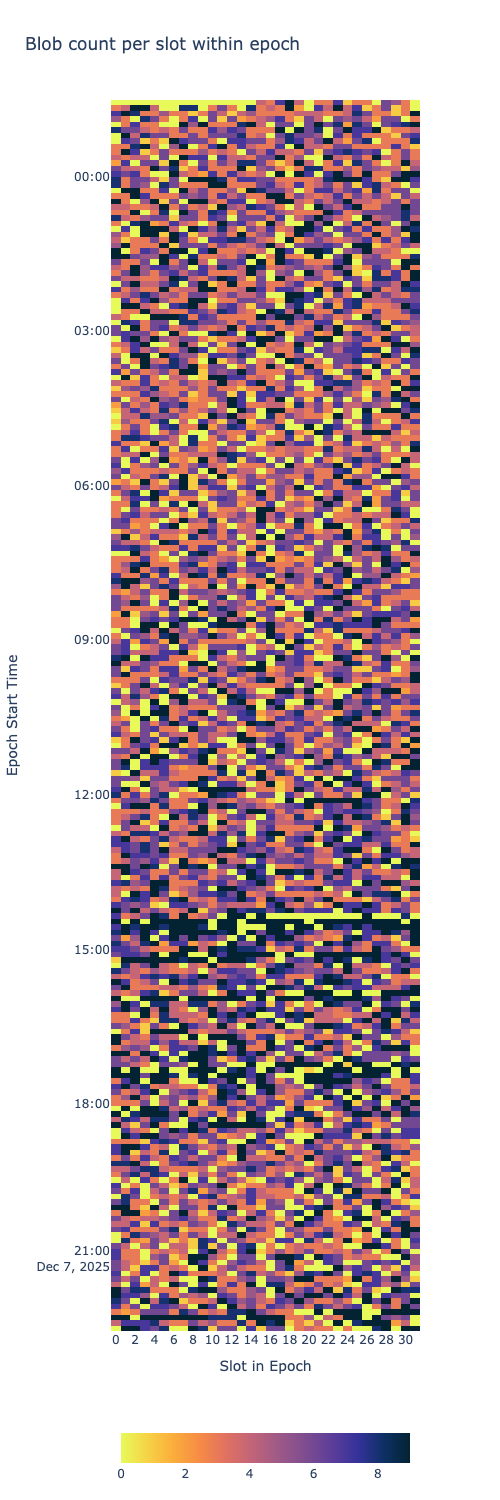

In [9]:
df_pivot = df_slot_in_epoch.pivot(index="slot_in_epoch", columns="time", values="blob_count").fillna(0)

fig = go.Figure(
    data=go.Heatmap(
        z=df_pivot.values.T,  # Transpose the data
        x=[str(int(s)) for s in df_pivot.index],  # Swap: slot_in_epoch on x-axis
        y=df_pivot.columns,  # Swap: time on y-axis
        colorscale="thermal",
        reversescale=True,
        colorbar=dict(
            orientation="h",  # Horizontal orientation
            y=-0.075,          # Position below the chart
            yanchor="top",
            x=0,
            xanchor="left",
            len=1,         # Length of the colorbar (0-1)
        ),
    )
)
fig.update_layout(
    title="Blob count per slot within epoch",
    xaxis_title="Slot in Epoch",  # Swap titles
    yaxis_title="Epoch Start Time",  # Swap titles
    yaxis=dict(autorange="reversed"),
    height=1500,
    width=500,
)
show_fig(fig)

## Blob count per slot (horizontal layout)

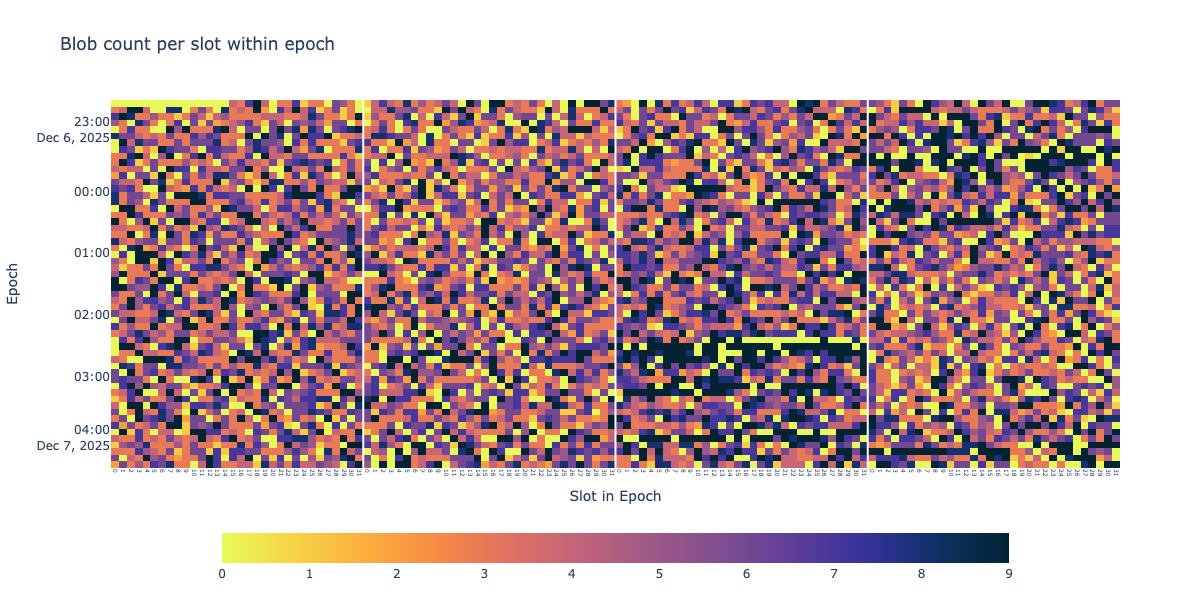

In [10]:
df_pivot = df_slot_in_epoch.pivot(index="slot_in_epoch", columns="time", values="blob_count").fillna(0)

# Parameters
n_columns = 4  # Number of horizontal partitions
n_rows = len(df_pivot.columns)
rows_per_chunk = n_rows // n_columns

# Reshape: stack chunks horizontally
chunks = []
for i in range(n_columns):
    chunk = df_pivot.T.iloc[i*rows_per_chunk:(i+1)*rows_per_chunk, :]
    chunk = chunk.reset_index(drop=True)
    chunks.append(chunk)

# Concatenate horizontally (side by side)
df_combined = pd.concat(chunks, axis=1, ignore_index=True)

# Create x-axis labels with dividers
n_slots = len(df_pivot.index)
x_labels = list(range(n_slots)) * n_columns

y_labels = []
for row_idx in range(rows_per_chunk):
    # Show time from first chunk, or you can format it differently
    time_val = df_pivot.columns[row_idx]
    y_labels.append(str(time_val))

fig = go.Figure(
    data=go.Heatmap(
        z=df_combined.values,
        x=list(range(len(df_combined.columns))),
        y=y_labels,  # Use actual epoch times
        colorscale="thermal",
        reversescale=True,
        colorbar=dict(
            orientation="h",
            y=-0.15,
            yanchor="top",
            x=0.5,
            xanchor="center",
            len=0.8,
        ),
    )
)

# Add vertical dividers between chunks
for i in range(1, n_columns):
    fig.add_vline(
        x=i * n_slots - 0.5,
        line_width=2,
        line_color="white",
    )

fig.update_layout(
    title="Blob count per slot within epoch",
    xaxis_title="Slot in Epoch",
    yaxis_title="Epoch",
    yaxis=dict(autorange="reversed"),
    xaxis=dict(
        tickvals=list(range(len(df_combined.columns))),
        ticktext=[str(i % n_slots) for i in range(len(df_combined.columns))],
        tickangle=90,
        tickfont=dict(size=6),
    ),
    height=600,
    width=1200,
)

show_fig(fig)